In [1]:
#@title Install Stability SDK with fine-tuning support
import os
import shutil
import sys
from pathlib import Path

if os.path.exists("../src/stability_sdk"):
    sys.path.append("../src") # use local SDK src
else:
    path = Path('stability-sdk')
    if path.exists():
        shutil.rmtree(path)
        !pip uninstall -y stability-sdk
    !git clone -b "PLATFORM-339" --recurse-submodules https://github.com/Stability-AI/stability-sdk
    !pip install ./stability-sdk

Cloning into 'stability-sdk'...
remote: Enumerating objects: 2857, done.
remote: Counting objects: 100% (1471/1471), done.
remote: Compressing objects: 100% (505/505), done.
remote: Total 2857 (delta 897), reused 1335 (delta 800), pack-reused 1386
Receiving objects: 100% (2857/2857), 47.80 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (1672/1672), done.
Submodule 'api-interfaces' (https://github.com/stability-ai/api-interfaces) registered for path 'src/stability_sdk/interfaces'
Cloning into '/content/stability-sdk/src/stability_sdk/interfaces'...
remote: Enumerating objects: 4455, done.        
remote: Counting objects: 100% (1579/1579), done.        
remote: Compressing objects: 100% (458/458), done.        
remote: Total 4455 (delta 1141), reused 1368 (delta 994), pack-reused 2876        
Receiving objects: 100% (4455/4455), 5.09 MiB | 8.96 MiB/s, done.
Resolving deltas: 100% (3180/3180), done.
Submodule path 'src/stability_sdk/interfaces': checked out 'a204ab7ffbb40e09a898107ef7c7

In [26]:
#@title Connect to the Stability API
import getpass
from stability_sdk.api import Context as ApiContext
from stability_sdk.finetune import *

# @markdown To get your API key visit https://dreamstudio.ai/account
STABILITY_HOST = "grpc-brian.stability.ai:443" #@param {type:"string"}
STABILITY_KEY = "sk-6or2rWAECxdobHfgz7n3WaqQbsw1W3VM29E3vkIQV1j4oz0t" #@param {type:"string"}
ft_engine_id = "stable-diffusion-xl-beta-v2-2-2-ft"

api_context = ApiContext(STABILITY_HOST, STABILITY_KEY, generate_engine_id=ft_engine_id)
(balance, pfp) = api_context.get_user_info()
print(f"Logged in org:{api_context._user_organization_id} with balance:{balance}")

# Create a fine-tuning context
ft_context = Context(STABILITY_HOST, STABILITY_KEY)

Logged in org:org-xHb87qibUiWagf9ylicb7C12 with balance:999990.8309599999


In [27]:
# List fine tuned models for this user / organization
models = list_models(ft_context, org_id=api_context._user_organization_id)
print(f"Found {len(models)} models")
for model in models:
    print(f"  Model {model.id} {model.name} {model.status}")

Found 4 models
  Model 31a3ea25-4e16-4e3d-96d5-06b01348c204 elliot-small completed
  Model c8cef2ec-d62e-4948-8189-c77f248a517a elliot completed
  Model 6408f646-6cc9-4911-b6c0-c9f30e7cab44 brian submitted
  Model 0a9a56ba-7b71-4c06-8f28-13716d0a54b4 brian2 submitted


In [14]:
#@title Upload input folder
from google.colab import files
from zipfile import ZipFile
import io
from pathlib import Path

upload_res = files.upload()
training_dir = list(upload_res.keys())[0]

print(training_dir)
zf = ZipFile(io.BytesIO(upload_res[training_dir]), "r")
zf.extractall()

training_dir = Path(training_dir).stem


Saving elliot-small.zip to elliot-small (8).zip
elliot-small.zip


In [43]:
import uuid
#@title Perform fine-tuning
model_name = "elliot" #@param {type:"string"}
training_mode = "face" #@param ["none", "face", "style", "object"] {type:"string"}

model_name += str(uuid.uuid4())[:4]

# Gather training images
images = []
for filename in os.listdir(training_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        images.append(os.path.join(training_dir, filename))

# Create the fine-tune model
params = FineTuneParameters(
    name=model_name,
    mode=FineTuneMode(training_mode),
    engine_id="stable-diffusion-xl-beta-v2-2-2",
)
model = create_model(ft_context, params, images)
print(f"Model {model_name} created.")
print(model)

Model elliot0133 created.
id='7fd3fbb0-b32f-4f6a-8b1c-3c7081585811' name='elliot0133' mode=<FineTuneMode.FACE: 'face'> object_name='' project_id='fe374d17-8e12-4fd8-b553-47f3a2240689' engine_id='' user_id='user-nxd0HKULOBWVrBY436QH7FEV' duration=0.0 status=<FineTuneStatus.SUBMITTED: 'submitted'>


In [45]:
import time
# Check on training status
start_time = time.time()
while model.status != FineTuneStatus.COMPLETED:
    model = get_model(ft_context, model.id)
    elapsed = time.time() - start_time
    print(f"Model {model.name} ({model.id}) status: {model.status} for {elapsed:.2f} sec")
    time.sleep(5)

In [ ]:
# If fine-tuning fails for some reason, you can resubmit the model
if model.status == FineTuneStatus.FAILED:
    print(f"Training failed, resubmitting")
    model = resubmit_model(ft_context, model.id)

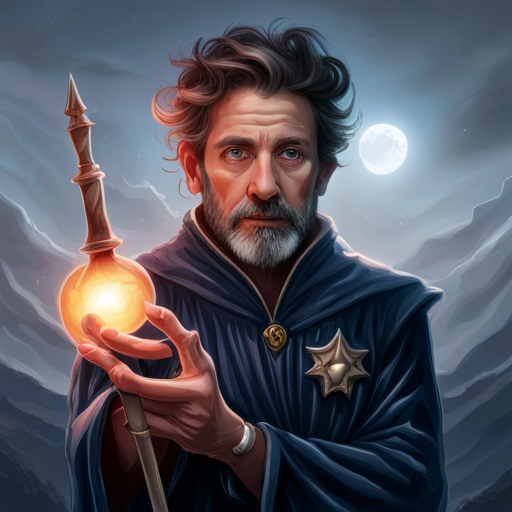

In [48]:
# Generate an image using the fine-tuned model
results = api_context.generate(
    ["Illustration of <s1><s2><s3> as a wizard"], [1], finetune_model=model.id
)
image = results[generation.ARTIFACT_IMAGE][0]
image

In [ ]:
# Models can be updated to change settings before a resubmit or after training to rename
update_model(ft_context, model.id, name="cat-ft-01-renamed")

In [ ]:
# Delete the model when it's no longer needed
delete_model(ft_context, model.id)